In [1]:
import numpy as np, numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import sepfir2d
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.color import rgb2gray

In [2]:
np.random.seed(42)

In [3]:
K_S = np.exp(-0.25 * np.array([4,1,0,1,4]))
K_D = K_S * np.array([2,1,0,-1,-2]) # sepfir2d

In [4]:
data_raw = imread("moon.jpg")
data = rgb2gray(data_raw)

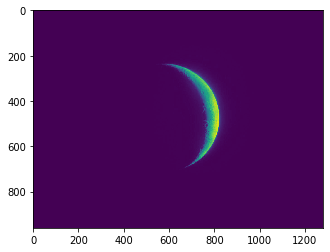

In [5]:
plt.imshow(data)

In [6]:
def extract_points(im, grad_th=None):
    grad_x = sepfir2d(im, K_D, K_S)
    grad_y = sepfir2d(im, K_S, K_D)
    grad_norm = np.sqrt(grad_x**2 + grad_y**2)
    grad_x /= grad_norm
    grad_y /= grad_norm
    if grad_th is None:
        grad_th = threshold_otsu(grad_norm)
    mask = (grad_norm >= grad_th).astype(bool)
    coords = np.vstack(np.where(mask))
    grads_x = grad_x[coords[0], coords[1]]
    grads_y = grad_y[coords[0], coords[1]]
    return np.vstack([coords[1], coords[0], grads_x, grads_y])

def random_sample(points, size):
    if points.shape[1] < size:
        return ma.array(np.zeros((4, size)), mask=np.ones((4, size)))
    ind = np.random.choice(points.shape[1], size, replace=False)
    return points[:,ind]

def circles_to_points(ims, size, grad_th=None):
    for im in ims:
        points = extract_points(im, grad_th)
        yield random_sample(points, size)

In [7]:
def mle_fit(points):
    if points.mask.any():
        return ma.array(np.zeros(4), mask=np.ones(4))
    
    mean_x   = points[0,:].mean()
    mean_y   = points[1,:].mean()
    mean_nx  = points[2,:].mean()
    mean_ny  = points[3,:].mean()
    mean_xnx = (points[0,:]*points[2,:]).mean()
    mean_yny = (points[1,:]*points[3,:]).mean()
    R = (mean_nx * mean_x + mean_ny * mean_y - mean_xnx - mean_yny) / (1.0 - mean_nx**2 - mean_ny**2)
    x0 = mean_x + R * mean_nx
    y0 = mean_y + R * mean_ny
    sigma2 = ((points[2,:] * (x0 - points[0,:]) + points[3,:] * (y0 - points[1,:]) - R)**2 + (points[3,:] * (x0 - points[0,:]) - points[2,:] * (y0 - points[1,:]))**2).mean() / 2
    return R,x0,y0,sigma2

In [8]:
data = data.reshape(1,*data.shape)

In [9]:
points = ma.array(list(circles_to_points(data, 30, 1.6)))[0,:,:]
mle_params = mle_fit(points)

/home/matwey/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/matwey/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


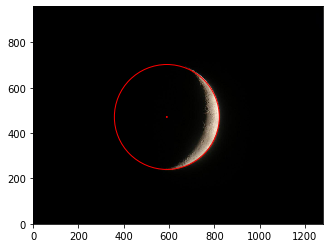

In [10]:
plt.imshow(data_raw, origin='lower', cmap=cm.Greys)
circle1 = plt.Circle((mle_params[1], mle_params[2]), mle_params[0], color='r', fill=False)
circle2 = plt.Circle((mle_params[1], mle_params[2]), 2.0, color='r', fill=True)
ax = plt.gca()
ax.add_artist(circle1)
ax.add_artist(circle2)
plt.savefig("moon.pdf")